# Fraud Detection Work

## Introduction and Motivation

The following code is intended for the final year project 'Machine Learning for Credit Card Fraud Detection' by Michael Brozhko.

### Combine CSVs of Dataset

Initially, the dataset uses was already pre split into training and testing data. However, for this experiment to be conducted with high validity, I recombined the dataset and randomly split later to ensure result reliability.

In [ ]:
import os

# The following code is intended to combine the two csv files associated with the dataset in use. 
# The dataset should be randomly split into testing and training data, as it is unclear how it was initially split

#NOTE: To run on another machine need to CHANGE PATH appropriately to download folder of initial dataset files

os.chdir("/Users/michael/Documents/Aston/FYP/Dataset")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

### Import Libraries

In [1]:
#import relevant libaries

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

from sklearn.svm import SVC
from IPython import display
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Load Dataset

Load the dataset into a pandas dataframe and output the data types

In [52]:
# load dataset into a new dataframe and show head
df = pd.read_csv("combined_csv.csv")
# List the initial datatypes of columns in dataframe
print(df.dtypes)
df.head()

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Data Preprocessing

In the data preprocessing stage we deal with:
    -Type conversions
    -Removal of unnecessary data
    -Reformatting of data to more model-friendly format

### Check For Null Values

In [53]:
print("Null values by column\n", df.isnull().sum())

Null values by column
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


### Datetime Column Seperation

This segment deals with seperating the datetime column into seperate columns - year, hour, day, month. 
There may be a correlation between different times of day, different days and different months with fraudulent activity.

In [54]:
#The following functionality aims to seperate the datetime column
#so that it can be processed as multiple features
#   -This can offer greater performance
#   -Allow the identification of trends with regards to specific days, time of day, etc

#define several empty lists for following functionality
df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
df['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
df['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
df['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month

df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
age                        int64
hour                       int64
day                        int64
month                      int64
dtype: object

### Feature Creation

In [55]:
# Add a feature that calculates the distance between the merchant and the customer for each transaction
df['merchant_customer_distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

df.dtypes

Unnamed: 0                      int64
trans_date_trans_time          object
cc_num                          int64
merchant                       object
category                       object
amt                           float64
first                          object
last                           object
gender                         object
street                         object
city                           object
state                          object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
job                            object
dob                            object
trans_num                      object
unix_time                       int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month       

### Removal of Unnecessary Features

In [56]:
df = df.drop(['Unnamed: 0','cc_num','trans_date_trans_time','first','street','last','trans_num','dob','merchant', 'unix_time'],axis=1)

In [57]:
print(df['state'].nunique())
print(df['city'].nunique())
print(df['job'].nunique())
print(df['category'].nunique())

51
906
497
14


In [58]:
df = df.drop(['city','job','state'],axis=1)
df.dtypes

category                       object
amt                           float64
gender                         object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
merchant_customer_distance    float64
dtype: object

### Feature and Label Seperation

In [60]:
# #labels (y) are the what we are trying to predict and as such, is the 'is_fraud' column
# y=dfn_more['is_fraud'].values
# #format data and for features (X) remove 'is_fraud' column since this is what we are trying to predict
# X=dfn_more.drop(['is_fraud'], axis='columns')

train_data, test_data = train_test_split(df, test_size=0.33, random_state=42)

train_data.dtypes

category                       object
amt                           float64
gender                         object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
merchant_customer_distance    float64
dtype: object

### Feature Encoding

Encoding categorical features

In [61]:
from sklearn.preprocessing import OneHotEncoder

#The following column deals with data preprocessing involving:
#   -Type conversions
#   -Removal of unnecessary data
#   -Reformatting of data to more model-friendly format

# Define the columns to encode
columns_to_encode = ['category','gender']

# Create an instance of the encoder
encoder = OneHotEncoder()

# Fit the encoder to the training data for the selected columns
encoder.fit(train_data[columns_to_encode])

# Apply the encoder to the training and test data for the selected columns
train_data_encoded = encoder.transform(train_data[columns_to_encode])
test_data_encoded = encoder.transform(test_data[columns_to_encode])

# Get the names of the encoded columns
encoded_column_names = encoder.get_feature_names_out(columns_to_encode)

# Create new DataFrames for the encoded columns
train_data_encoded_df = pd.DataFrame(train_data_encoded.toarray(), columns=encoded_column_names)
test_data_encoded_df = pd.DataFrame(test_data_encoded.toarray(), columns=encoded_column_names)

# Drop the original columns from the training and test data
train_data = train_data.drop(columns_to_encode, axis=1)
test_data = test_data.drop(columns_to_encode, axis=1)

# Concatenate the encoded columns with the remaining columns
train_data = pd.concat([train_data, train_data_encoded_df], axis=1)
test_data = pd.concat([test_data, test_data_encoded_df], axis=1)

In [62]:
train_data.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
2768116,65.57,4616.0,44.2541,-68.5565,824.0,43.294795,-68.718689,0.0,49.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2144879,89.78,23937.0,36.9688,-78.5615,1970.0,36.004118,-78.382052,0.0,38.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1122045,22.99,28405.0,34.2651,-77.8670,186140.0,34.565603,-77.762061,0.0,40.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811251,8.70,36775.0,32.2844,-86.9920,800.0,31.737033,-87.710055,0.0,91.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
899749,17.97,52572.0,40.6866,-92.6833,1132.0,40.340462,-92.348096,0.0,62.0,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
train_data=train_data.dropna()
train_data.head()


,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
2768116,65.57,4616.0,44.2541,-68.5565,824.0,43.294795,-68.718689,0.0,49.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2144879,89.78,23937.0,36.9688,-78.5615,1970.0,36.004118,-78.382052,0.0,38.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1122045,22.99,28405.0,34.2651,-77.8670,186140.0,34.565603,-77.762061,0.0,40.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811251,8.70,36775.0,32.2844,-86.9920,800.0,31.737033,-87.710055,0.0,91.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
899749,17.97,52572.0,40.6866,-92.6833,1132.0,40.340462,-92.348096,0.0,62.0,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
test_data=test_data.dropna()
test_data.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
299520,37.58,52535.0,40.8626,-91.9534,888.0,40.781342,-92.768611,0.0,35.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1725905,49.80,67584.0,38.6411,-100.1380,269.0,39.015727,-100.089812,0.0,61.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
389829,42.86,57732.0,44.3566,-103.6999,1979.0,45.088857,-103.720708,0.0,53.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1118075,4.33,70774.0,30.2385,-90.8435,10076.0,29.881234,-90.980444,0.0,46.0,15.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1184622,136.12,43408.0,41.5686,-83.3632,269.0,42.343209,-82.738339,0.0,58.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [65]:
train_data.dtypes

amt                           float64
zip                           float64
lat                           float64
long                          float64
city_pop                      float64
merch_lat                     float64
merch_long                    float64
is_fraud                      float64
age                           float64
hour                          float64
day                           float64
month                         float64
merchant_customer_distance    float64
category_entertainment        float64
category_food_dining          float64
category_gas_transport        float64
category_grocery_net          float64
category_grocery_pos          float64
category_health_fitness       float64
category_home                 float64
category_kids_pets            float64
category_misc_net             float64
category_misc_pos             float64
category_personal_care        float64
category_shopping_net         float64
category_shopping_pos         float64
category_tra

### Outlier Detection and Removal

In [66]:
# calculate correlations between all columns and is_fraud
corr_matrix = train_data.corr()['is_fraud']

# print correlations in descending order
print(corr_matrix.sort_values(ascending=False))

is_fraud                      1.000000
amt                           0.208039
hour                          0.013556
age                           0.011496
day                           0.004039
lat                           0.002966
merch_lat                     0.002789
category_misc_pos             0.000765
category_grocery_net          0.000680
long                          0.000596
category_entertainment        0.000586
merch_long                    0.000577
category_health_fitness       0.000569
gender_F                      0.000499
category_misc_net             0.000325
category_grocery_pos          0.000201
merchant_customer_distance    0.000090
category_kids_pets            0.000010
city_pop                     -0.000025
category_food_dining         -0.000119
category_shopping_pos        -0.000178
category_shopping_net        -0.000346
category_home                -0.000374
category_personal_care       -0.000471
gender_M                     -0.000499
category_gas_transport   

In [53]:
def get_min_max_no_outliers(df, col1, col2):
    # Calculate the interquartile range (IQR) for each column
    Q1 = df[[col1, col2]].quantile(0.25)
    Q3 = df[[col1, col2]].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    outlier_threshold = 1.5

    # Define non-outlier range for each column
    min_val = Q1 - outlier_threshold * IQR
    max_val = Q3 + outlier_threshold * IQR

    # Filter the DataFrame to exclude outliers
    df_filtered = df[(df[col1] >= min_val[col1]) & (df[col1] <= max_val[col1]) &
                     (df[col2] >= min_val[col2]) & (df[col2] <= max_val[col2])]

    print("Minimum Values:\n",df_filtered[[col1, col2]].min())
    print("Maximum Values:\n",df_filtered[[col1, col2]].max())

get_min_max_no_outliers(train_data, 'age', 'amt')

Minimum Values:
 age    18.0
amt     1.0
dtype: float64
Maximum Values:
 age     98.00
amt    193.18
dtype: float64


In [17]:
print(len(train_data))
train_data = train_data[train_data['age']<=98]
print(len(train_data))

2494717
2493743


In [18]:
y_train=train_data['is_fraud']
X_train=train_data.drop(['is_fraud'], axis='columns')

y_test=test_data['is_fraud']
X_test=test_data.drop(['is_fraud'], axis='columns')

### Principle Component Analysis

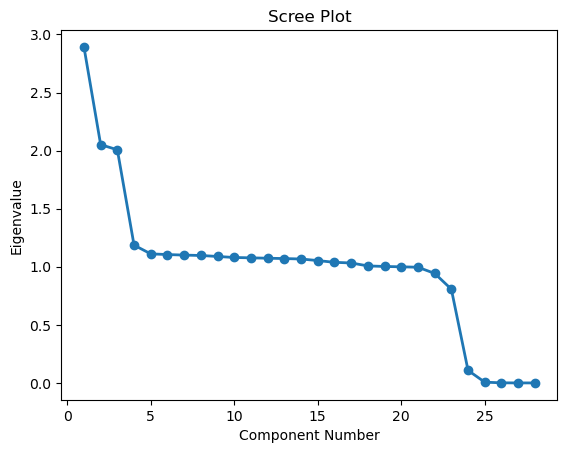

     amt    zip    lat   long  city_pop  merch_lat  merch_long    age   hour  \
0  10.33  7.326  7.167  4.236     3.968      3.947        3.93  3.918  3.888   

     day  month  merchant_customer_distance  category_entertainment  \
0  3.856  3.846                       3.834                   3.823   

   category_food_dining  category_gas_transport  category_grocery_net  \
0                  3.81                   3.762                 3.708   

   category_grocery_pos  category_health_fitness  category_home  \
0                 3.688                    3.598           3.58   

   category_kids_pets  category_misc_net  category_misc_pos  \
0                3.57              3.557              3.368   

   category_personal_care  category_shopping_net  category_shopping_pos  \
0                   2.881                  0.385                  0.023   

   category_travel   gender_F   gender_M  
0            0.003  3.120e-28  9.213e-29  


In [21]:
from sklearn.discriminant_analysis import StandardScaler


def pca_analysis(features):
    scaled = StandardScaler().fit_transform(features)
    cs = features.columns
    pca = PCA()
    pca.fit(scaled)
    
    # Calculate the eigenvalues of the principal components
    eigenvalues = pca.explained_variance_

    # Plot the scree plot
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2)
    plt.xlabel('Component Number')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')
    plt.show()

    values = pca.explained_variance_ratio_ * 100

    result = pd.DataFrame(data=[values],columns=cs)

    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
        print(result)
    
pca_analysis(X_train)

In [22]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_colwidth', None)

### Final Column Selection

Based on PCA results certain features are selected while others are discarded

In [23]:
X_train = X_train[['amt','zip','lat','long','age','hour','day','month','merchant_customer_distance']]
X_test = X_test[['amt','zip','lat','long','age','hour','day','month','merchant_customer_distance']]


In [24]:
X_train.head()

,amt,zip,lat,long,age,hour,day,month,merchant_customer_distance
2768116,65.57,4616.0,44.2541,-68.5565,49.0,23.0,6.0,12.0,0.972919
2144879,89.78,23937.0,36.9688,-78.5615,38.0,4.0,4.0,5.0,0.981230
1122045,22.99,28405.0,34.2651,-77.8670,40.0,14.0,6.0,4.0,0.318299
811251,8.70,36775.0,32.2844,-86.9920,91.0,7.0,5.0,12.0,0.902892
899749,17.97,52572.0,40.6866,-92.6833,62.0,20.0,3.0,12.0,0.481844


## Key Functions

### plotResults()
The following function is defined to plot results based on a parameter 'report' which is a passed classification report

In [25]:
def plotResults(report,model):
    df = pd.DataFrame(report)
    df.iloc[:3, :2].T.plot(kind='bar')
    plt.title(model)
    plt.xlabel('Class')
    plt.ylabel('Performance')
    plt.show()

In [47]:
from sklearn.metrics import make_scorer, recall_score, precision_score

def modelPerformance(pipe, name, parameters,X_train,y_train,X_test,y_test):

    print(name)

    # Perform hyperparameter tuning using GridSearchCV and the validation set
    scorer = make_scorer(recall_score,pos_label=1)
    grid_search = GridSearchCV(pipe, parameters, cv=5,scoring=scorer)

    print("fitting")
    grid_search.fit(X_train, y_train)
    
    print(name,': ',grid_search.best_params_)

    best_estimator = grid_search.best_estimator_
    best_estimator.fit(X_train, y_train)

    print(name," best estimator fitted")
    
    Y_trainPred = best_estimator.predict(X_train)
    print(name," Train Accuracy: ",accuracy_score(y_train, Y_trainPred))
    print(name," Train Scores\n",classification_report(y_train, Y_trainPred))
    
    Y_testPred = best_estimator.predict(X_test)
    print(name," Test Accuracy: ",accuracy_score(y_test, Y_testPred))
    print(name," Test Scores\n",classification_report(y_test, Y_testPred))

    plotResults(classification_report(y_train, Y_trainPred, digits=4,  output_dict=True),name+' Classifier Train Score')
    plotResults(classification_report(y_test, Y_testPred, digits=4,  output_dict=True),name+' Classifier Test Score')
    

### RunModels()

Main function called to run the desired Machine Learning models on specified parameters for features (X) and labels (y)

This function makes calls to the various prior defined functions.

Certain models are commented out/in for testing purposes. For reviewing models, comment/uncomment different code blocks.

In [48]:
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline

# Function to run pipelines

# Avoids code repitiion by encapsulating all functionality in the function, allowing models on different data splits 
# and sample sizes to be run by calling function and passing relevamt parameters


# The function takes the features (x), labels (y) train and test variables aswell as a sampler which can be set to 'none' 
# Performs:
#     1. Train-testing data split
#     2. Model training and testing
#     3. Output of performance metrics through classification_report

# The function does not return anything

def runPipelines(X_train,y_train,X_test,y_test,sampler):

    ## check if sampling method passed and if yes, resamples the data based on this
    if(sampler==None):
        print("No sampling")
    else:
        print(sampler)
        ros = sampler
        X_train, y_train = ros.fit_resample(X_train, y_train)
    
    parameters = {
        'knn__n_jobs': [-1],
        'knn__weights': ['distance'],
        'knn__n_neighbors': [4,5,6]
    }
    
    knnPipe = imbpipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    modelPerformance(knnPipe,'KNN',parameters,X_train,y_train,X_test,y_test)
    

    parameters = {
        'xgb__n_jobs': [-1],
        'xgb__min_child_weight': [1],
        'xgb__objective': ['binary:logistic'],
        'xgb__reg_alpha': [0.1],
        'xgb__reg_lambda': [0.1],
        'xgb__max_depth': [15,25],
        'xgb__learning_rate': [0.05, 0.1],
        'xgb__n_estimators': [150,200]
    }

    xgbPipe = imbpipeline([
        ('scaler', StandardScaler()),
        ('xgb', xgb.XGBClassifier())
    ])

    modelPerformance(xgbPipe,'XGB' ,parameters,X_train,y_train,X_test,y_test)
    
    parameters = {
        'rf__n_jobs': [-1],
        'rf__n_estimators': [150,200],
        'rf__max_depth': [15,25]
    }

    rfPipe = imbpipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier())
    ])

    modelPerformance(rfPipe,'Random Forest', parameters,X_train,y_train,X_test,y_test)

    parameters = {
        'mlp__max_iter': [1200],
        'mlp__activation': ['tanh','relu'],
        'mlp__hidden_layer_sizes': [(100, 75), (100, 70, 45)],
    }
    
    mlpPipe = imbpipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier())
    ])

    modelPerformance(mlpPipe,'MLP', parameters,X_train,y_train,X_test,y_test)


## Final Results

Results analysis using the above functions is conducted on Random Oversampled data 10:1, and unsampled data

None
KNN
fitting
KNN :  {'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
KNN  best estimator fitted
KNN  Train Accuracy:  1.0
KNN  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       1.00      1.00      1.00     12917

    accuracy                           1.00   2493743
   macro avg       1.00      1.00      1.00   2493743
weighted avg       1.00      1.00      1.00   2493743

KNN  Test Accuracy:  0.998479052251168
KNN  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.89      0.82      0.85      3223

    accuracy                           1.00    604886
   macro avg       0.94      0.91      0.93    604886
weighted avg       1.00      1.00      1.00    604886



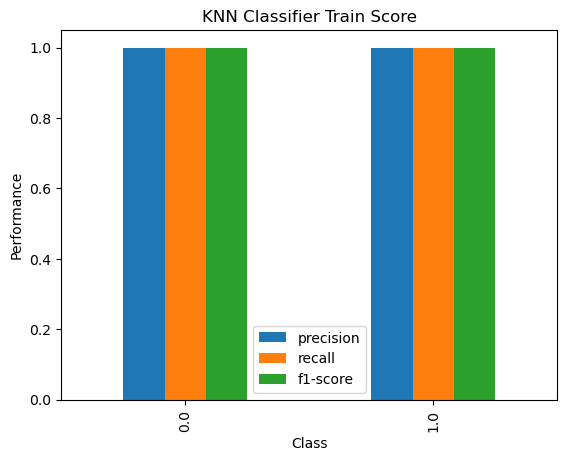

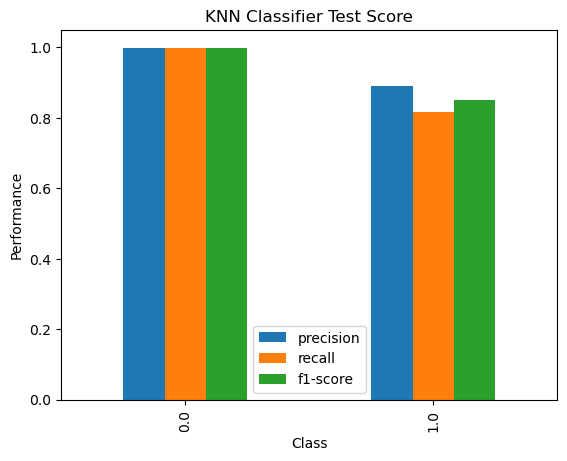

XGB
fitting
XGB :  {'xgb__learning_rate': 0.1, 'xgb__max_depth': 15, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__n_jobs': -1, 'xgb__objective': 'binary:logistic', 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 0.1}
XGB  best estimator fitted
XGB  Train Accuracy:  0.999988771898307
XGB  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       1.00      1.00      1.00     12917

    accuracy                           1.00   2493743
   macro avg       1.00      1.00      1.00   2493743
weighted avg       1.00      1.00      1.00   2493743

XGB  Test Accuracy:  0.9990179967795585
XGB  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.96      0.85      0.90      3223

    accuracy                           1.00    604886
   macro avg       0.98      0.92      0.95    604886
weighted avg       1.00      1.

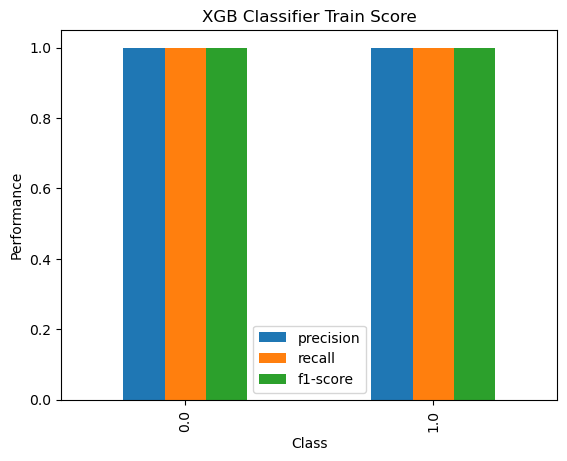

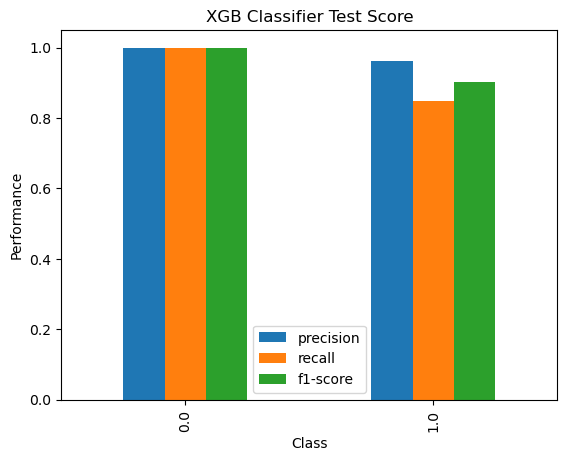

Random Forest
fitting
Random Forest :  {'rf__max_depth': 25, 'rf__n_estimators': 150, 'rf__n_jobs': -1}
Random Forest  best estimator fitted
Random Forest  Train Accuracy:  0.9998568417034153
Random Forest  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       1.00      0.97      0.99     12917

    accuracy                           1.00   2493743
   macro avg       1.00      0.99      0.99   2493743
weighted avg       1.00      1.00      1.00   2493743

Random Forest  Test Accuracy:  0.9987154604338668
Random Forest  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.95      0.80      0.87      3223

    accuracy                           1.00    604886
   macro avg       0.98      0.90      0.93    604886
weighted avg       1.00      1.00      1.00    604886



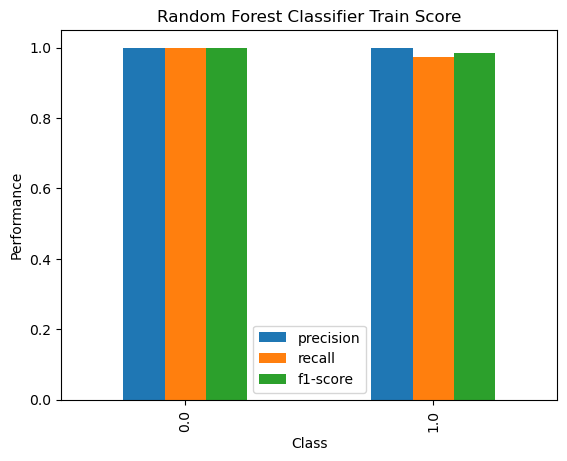

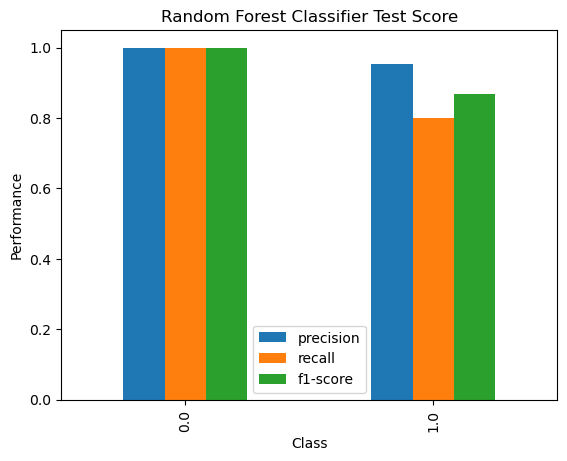

MLP
fitting
MLP :  {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (100, 70, 45), 'mlp__max_iter': 1200}
MLP  best estimator fitted
MLP  Train Accuracy:  0.9968553295187195
MLP  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       0.81      0.51      0.63     12917

    accuracy                           1.00   2493743
   macro avg       0.90      0.76      0.81   2493743
weighted avg       1.00      1.00      1.00   2493743

MLP  Test Accuracy:  0.9966059720343998
MLP  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.79      0.49      0.61      3223

    accuracy                           1.00    604886
   macro avg       0.89      0.75      0.80    604886
weighted avg       1.00      1.00      1.00    604886



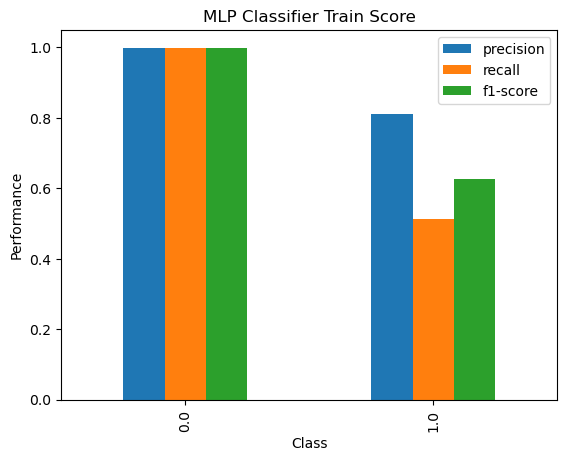

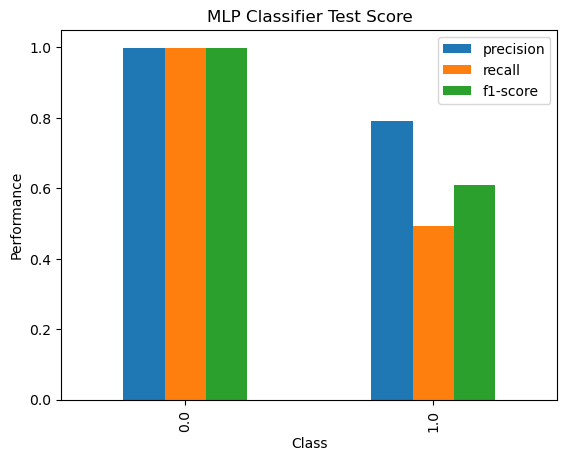

In [29]:
## run pipelines on unsampled data
runPipelines(X_train,y_train,X_test,y_test,None)

RandomOverSampler(random_state=42, sampling_strategy=0.1)
KNN
fitting
KNN :  {'knn__n_jobs': -1, 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
KNN  best estimator fitted
KNN  Train Accuracy:  1.0
KNN  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       1.00      1.00      1.00    248082

    accuracy                           1.00   2728908
   macro avg       1.00      1.00      1.00   2728908
weighted avg       1.00      1.00      1.00   2728908

KNN  Test Accuracy:  0.9980740172528377
KNN  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.81      0.84      0.82      3223

    accuracy                           1.00    604886
   macro avg       0.90      0.92      0.91    604886
weighted avg       1.00      1.00      1.00    604886



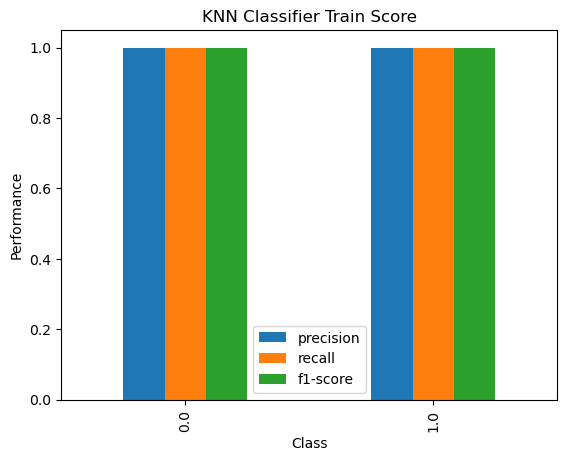

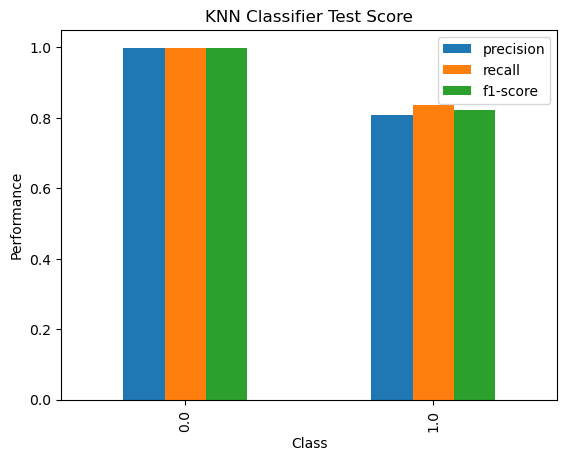

XGB
fitting
XGB :  {'xgb__learning_rate': 0.05, 'xgb__max_depth': 25, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__n_jobs': -1, 'xgb__objective': 'binary:logistic', 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 0.1}
XGB  best estimator fitted
XGB  Train Accuracy:  0.9999948697427689
XGB  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       1.00      1.00      1.00    248082

    accuracy                           1.00   2728908
   macro avg       1.00      1.00      1.00   2728908
weighted avg       1.00      1.00      1.00   2728908

XGB  Test Accuracy:  0.9988444103517027
XGB  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.91      0.87      0.89      3223

    accuracy                           1.00    604886
   macro avg       0.95      0.94      0.94    604886
weighted avg       1.00      

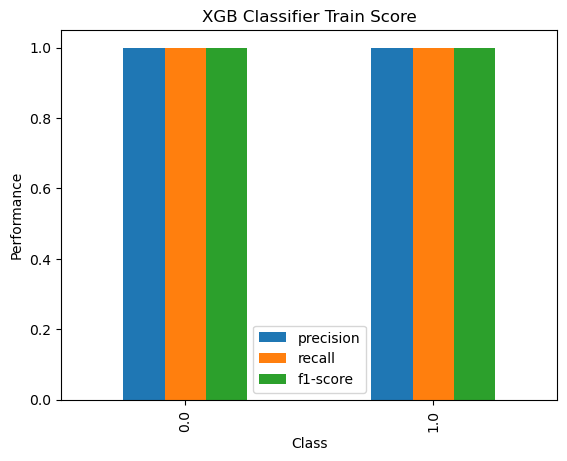

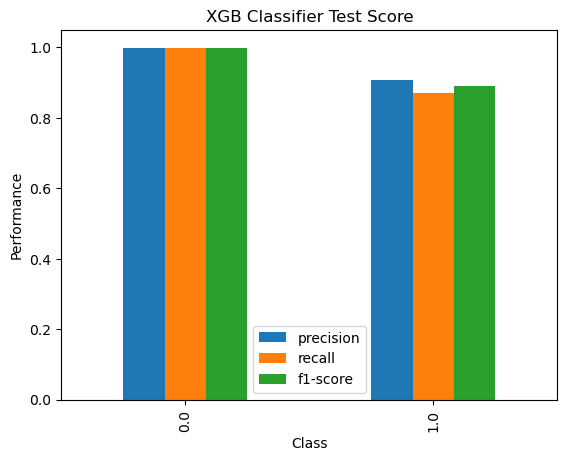

Random Forest
fitting
Random Forest :  {'rf__max_depth': 25, 'rf__n_estimators': 150, 'rf__n_jobs': -1}
Random Forest  best estimator fitted
Random Forest  Train Accuracy:  0.9998644146303209
Random Forest  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       1.00      1.00      1.00    248082

    accuracy                           1.00   2728908
   macro avg       1.00      1.00      1.00   2728908
weighted avg       1.00      1.00      1.00   2728908

Random Forest  Test Accuracy:  0.9988725148209745
Random Forest  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.92      0.87      0.89      3223

    accuracy                           1.00    604886
   macro avg       0.96      0.93      0.95    604886
weighted avg       1.00      1.00      1.00    604886



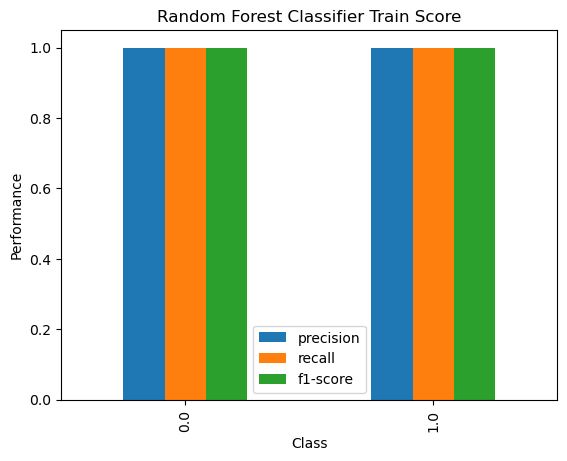

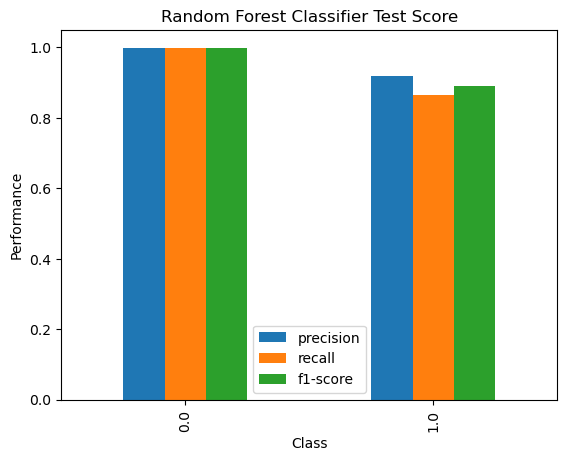

MLP
fitting
MLP :  {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (100, 70, 45), 'mlp__max_iter': 1200}
MLP  best estimator fitted
MLP  Train Accuracy:  0.9952702692798732
MLP  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2480826
         1.0       0.96      0.98      0.97    248082

    accuracy                           1.00   2728908
   macro avg       0.98      0.99      0.99   2728908
weighted avg       1.00      1.00      1.00   2728908

MLP  Test Accuracy:  0.9943609209007979
MLP  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.48      0.85      0.62      3223

    accuracy                           0.99    604886
   macro avg       0.74      0.92      0.81    604886
weighted avg       1.00      0.99      1.00    604886



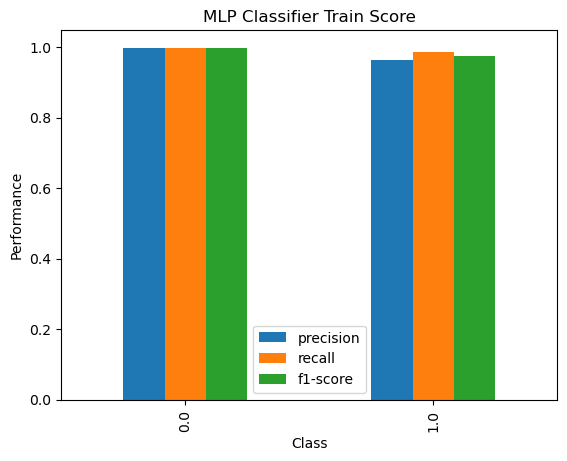

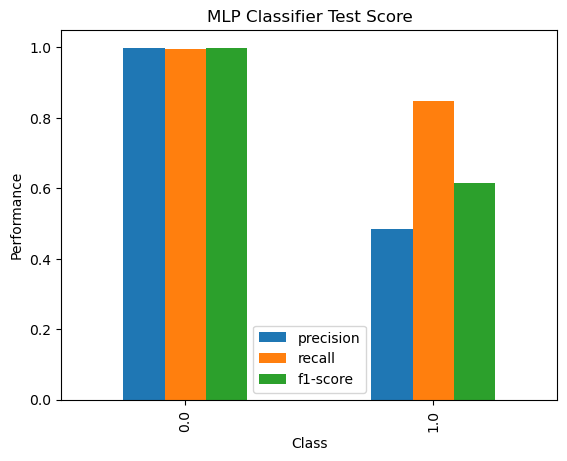

In [40]:
## run pipelines on randomly oversampled data 10:1
runPipelines(X_train,y_train,X_test,y_test,RandomOverSampler(random_state=42,sampling_strategy=0.1))
